# Video: Building an Image Classification Model Using LeNet

In [1]:
#SPLIT THE LIBRARIES TO THEIR RESPECTIVE CELLS
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from PIL import Image
from tqdm import tqdm

In [2]:
class HarDataset(Dataset):
    def __init__(self, root_dir, data, transform=None):
        self.root_dir = root_dir
        self.data_df = data
        self.transform = transform
        self.label_map = self._create_label_map()

    def __len__(self):
        return len(self.data_df)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.data_df.iloc[idx, 0])
        image = Image.open(img_name)
        label = self.data_df.iloc[idx, 1]
        label = self.label_map[label]

        if self.transform:
            image = self.transform(image)

        return image, label

    def _create_label_map(self):
        unique_labels = sorted(self.data_df['label'].unique())
        label_map = {label: idx for idx, label in enumerate(unique_labels)}
        return label_map

In [3]:
# Define transforms for data augmentation

# Use this for colored images
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
])

# Use this for BnW images
# transform = transforms.Compose([
#     transforms.Resize((32, 32)),
#     transforms.Grayscale(num_output_channels=1),  # Convert to black and white
#     transforms.ToTensor(),
# ])

In [4]:
train_root_dir = r'C:\Users\Deepak\Downloads\Computer Vision Resources\Human Action Recognition\New_train'
train_file = r'C:\Users\Deepak\Downloads\Computer Vision Resources\Human Action Recognition\Modified_Training_set.csv'
test_root_dir = r'C:\Users\Deepak\Downloads\Computer Vision Resources\Human Action Recognition\New_test'
test_file = r'C:\Users\Deepak\Downloads\Computer Vision Resources\Human Action Recognition\Reduced_Testing_set.csv'

In [5]:
df_train = pd.read_csv(train_file)
df_test = pd.read_csv(test_file)

In [6]:
df_train, df_val = train_test_split(df_train, test_size=0.2, stratify=df_train.label)

C:\Users\Deepak\anaconda3\envs\dl_intro\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Deepak\anaconda3\envs\dl_intro\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


In [7]:
df_train.shape, df_val.shape

((3360, 2), (840, 2))

In [8]:
# Create train and test datasets
train_dataset = HarDataset(root_dir=train_root_dir, data=df_train, transform=transform)
val_dataset = HarDataset(root_dir=train_root_dir, data=df_val, transform=transform)

In [9]:
# Define data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [10]:
output_label_map = {val: key for (key, val) in train_dataset.label_map.items()}

In [11]:
for x, y in train_loader:
    print(x.shape)
    print(y)
    break

torch.Size([32, 3, 32, 32])
tensor([0, 2, 2, 1, 1, 0, 0, 0, 2, 2, 2, 4, 0, 4, 0, 4, 0, 1, 3, 3, 2, 2, 2, 1,
        3, 0, 4, 2, 4, 2, 2, 1])


In [12]:
# Count the number of unique labels
num_classes = len(train_dataset.label_map)

In [13]:
num_classes

5

label
sleeping    672
fighting    672
drinking    672
texting     672
sitting     672
Name: count, dtype: int64


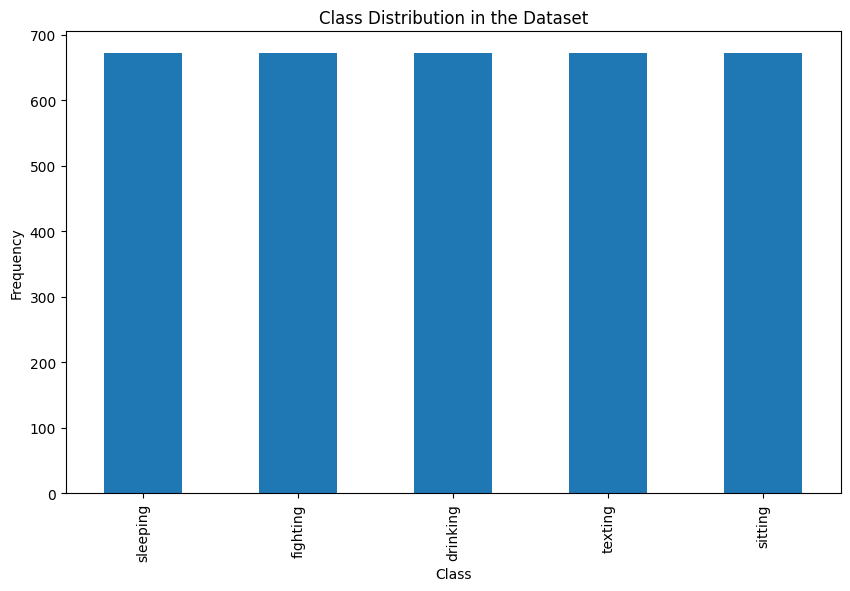

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# Checking class distribution
class_distribution = df_train['label'].value_counts()

# Print the class distribution
print(class_distribution)

# Plotting the class distribution
plt.figure(figsize=(10, 6))
class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Class Distribution in the Dataset')
plt.show()


### LeNet Architecture

In [15]:
# Define LeNet-5 model
class LeNet5(nn.Module):
    def __init__(self, num_classes=num_classes):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        x = torch.nn.functional.relu(self.conv1(x))
        x = torch.nn.functional.max_pool2d(x, kernel_size=2, stride=2)
        x = torch.nn.functional.relu(self.conv2(x))
        x = torch.nn.functional.max_pool2d(x, kernel_size=2, stride=2)
        x = torch.flatten(x, 1)
        x = torch.nn.functional.relu(self.fc1(x))
        x = torch.nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [16]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [17]:
device

device(type='cpu')

In [18]:
# Initialize LeNet-5 model
model = LeNet5().to(device)

In [19]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [20]:
# Train the model
num_epochs = 20
best_accuracy = 0.0
epochs_since_best = 0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100. * correct / total

    # Evaluate the model
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = outputs.max(1)

            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = 100. * correct / total

    print(f'Epoch [{epoch + 1}/{num_epochs}], '
          f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, '
          f'Test Loss: {val_loss:.4f}, Test Accuracy: {val_accuracy:.2f}%')

    # Check for best accuracy and stop if not improved after two more epochs
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        epochs_since_best = 0
        print(f'New best accuracy: {best_accuracy:.2f}%')
    else:
        epochs_since_best += 1
        if epochs_since_best > 2:
            print("Stopping early: no improvement after two consecutive epochs.")
            break


100%|████████████████████████████████████████████████████████████████████████████████| 105/105 [00:03<00:00, 26.85it/s]


Epoch [1/20], Train Loss: 1.5980, Train Accuracy: 22.44%, Test Loss: 1.5636, Test Accuracy: 30.83%
New best accuracy: 30.83%


100%|████████████████████████████████████████████████████████████████████████████████| 105/105 [00:03<00:00, 29.41it/s]


Epoch [2/20], Train Loss: 1.5020, Train Accuracy: 32.35%, Test Loss: 1.4756, Test Accuracy: 34.40%
New best accuracy: 34.40%


100%|████████████████████████████████████████████████████████████████████████████████| 105/105 [00:03<00:00, 27.21it/s]


Epoch [3/20], Train Loss: 1.4737, Train Accuracy: 35.92%, Test Loss: 1.4571, Test Accuracy: 37.02%
New best accuracy: 37.02%


100%|████████████████████████████████████████████████████████████████████████████████| 105/105 [00:04<00:00, 25.41it/s]


Epoch [4/20], Train Loss: 1.4399, Train Accuracy: 36.46%, Test Loss: 1.4288, Test Accuracy: 39.64%
New best accuracy: 39.64%


100%|████████████████████████████████████████████████████████████████████████████████| 105/105 [00:04<00:00, 25.61it/s]


Epoch [5/20], Train Loss: 1.4040, Train Accuracy: 40.21%, Test Loss: 1.4304, Test Accuracy: 38.45%


100%|████████████████████████████████████████████████████████████████████████████████| 105/105 [00:04<00:00, 25.27it/s]


Epoch [6/20], Train Loss: 1.4071, Train Accuracy: 39.23%, Test Loss: 1.4113, Test Accuracy: 38.45%


100%|████████████████████████████████████████████████████████████████████████████████| 105/105 [00:03<00:00, 27.94it/s]


Epoch [7/20], Train Loss: 1.3701, Train Accuracy: 42.95%, Test Loss: 1.3529, Test Accuracy: 42.50%
New best accuracy: 42.50%


100%|████████████████████████████████████████████████████████████████████████████████| 105/105 [00:03<00:00, 29.00it/s]


Epoch [8/20], Train Loss: 1.3359, Train Accuracy: 44.64%, Test Loss: 1.3558, Test Accuracy: 42.50%


100%|████████████████████████████████████████████████████████████████████████████████| 105/105 [00:03<00:00, 27.45it/s]


Epoch [9/20], Train Loss: 1.3039, Train Accuracy: 44.94%, Test Loss: 1.3681, Test Accuracy: 42.50%


100%|████████████████████████████████████████████████████████████████████████████████| 105/105 [00:04<00:00, 25.83it/s]


Epoch [10/20], Train Loss: 1.2977, Train Accuracy: 45.12%, Test Loss: 1.3485, Test Accuracy: 44.52%
New best accuracy: 44.52%


100%|████████████████████████████████████████████████████████████████████████████████| 105/105 [00:04<00:00, 25.39it/s]


Epoch [11/20], Train Loss: 1.2720, Train Accuracy: 48.04%, Test Loss: 1.3101, Test Accuracy: 46.55%
New best accuracy: 46.55%


100%|████████████████████████████████████████████████████████████████████████████████| 105/105 [00:03<00:00, 27.73it/s]


Epoch [12/20], Train Loss: 1.2205, Train Accuracy: 50.03%, Test Loss: 1.3299, Test Accuracy: 44.88%


100%|████████████████████████████████████████████████████████████████████████████████| 105/105 [00:03<00:00, 27.60it/s]


Epoch [13/20], Train Loss: 1.1938, Train Accuracy: 51.67%, Test Loss: 1.2771, Test Accuracy: 47.62%
New best accuracy: 47.62%


100%|████████████████████████████████████████████████████████████████████████████████| 105/105 [00:03<00:00, 29.01it/s]


Epoch [14/20], Train Loss: 1.1740, Train Accuracy: 52.68%, Test Loss: 1.3295, Test Accuracy: 45.48%


100%|████████████████████████████████████████████████████████████████████████████████| 105/105 [00:03<00:00, 27.96it/s]


Epoch [15/20], Train Loss: 1.1539, Train Accuracy: 53.10%, Test Loss: 1.2513, Test Accuracy: 48.45%
New best accuracy: 48.45%


100%|████████████████████████████████████████████████████████████████████████████████| 105/105 [00:03<00:00, 28.43it/s]


Epoch [16/20], Train Loss: 1.1129, Train Accuracy: 54.29%, Test Loss: 1.2929, Test Accuracy: 49.05%
New best accuracy: 49.05%


100%|████████████████████████████████████████████████████████████████████████████████| 105/105 [00:03<00:00, 29.27it/s]


Epoch [17/20], Train Loss: 1.0908, Train Accuracy: 56.46%, Test Loss: 1.2897, Test Accuracy: 46.31%


100%|████████████████████████████████████████████████████████████████████████████████| 105/105 [00:03<00:00, 28.20it/s]


Epoch [18/20], Train Loss: 1.0707, Train Accuracy: 57.17%, Test Loss: 1.2714, Test Accuracy: 47.86%


100%|████████████████████████████████████████████████████████████████████████████████| 105/105 [00:03<00:00, 29.61it/s]


Epoch [19/20], Train Loss: 1.0469, Train Accuracy: 58.90%, Test Loss: 1.2812, Test Accuracy: 48.45%
Stopping early: no improvement after two consecutive epochs.


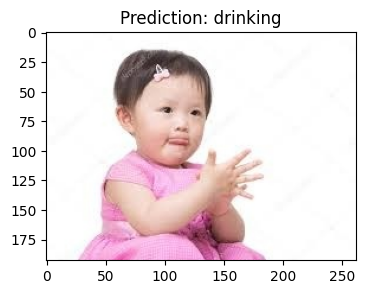

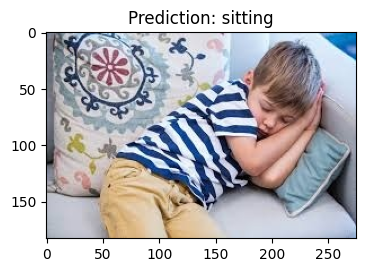

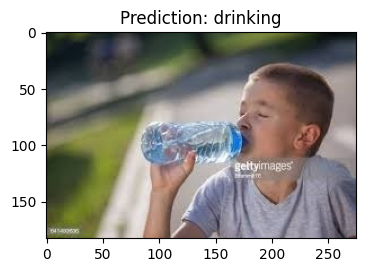

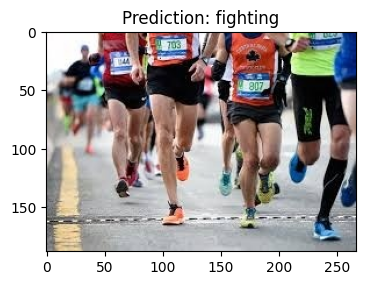

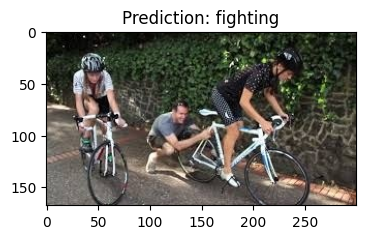

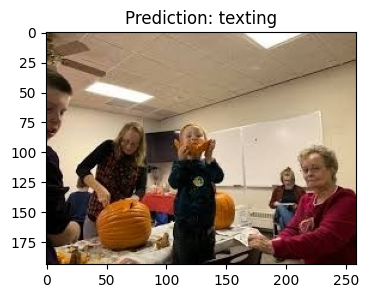

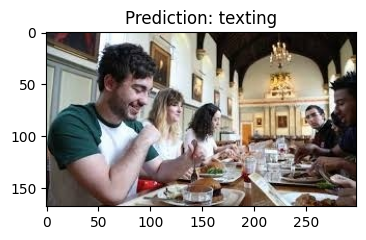

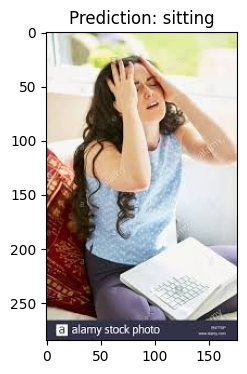

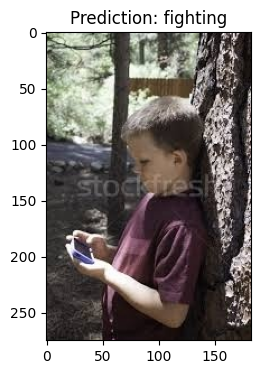

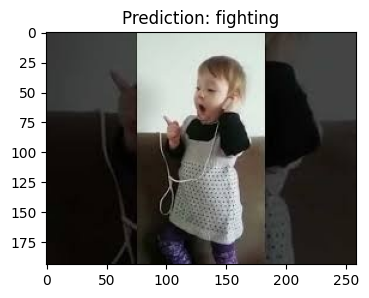

In [22]:
for idx, row in df_test.sample(10).iterrows():
    img_path = os.path.join(test_root_dir, row['filename'])  
    image_true = Image.open(img_path)  # Open the image file

    # Transform the image and add a batch dimension
    image = transform(image_true).unsqueeze(0).to(device)

    # Pass the image through the model without computing gradients
    with torch.no_grad():
        output = model(image)

    # Get the predicted class label by finding the maximum in the output tensor
    predicted_class = torch.argmax(output).item()

    # Plot the image along with the predicted class label
    plt.figure(figsize=(4, 4))
    plt.imshow(image_true)
    plt.title(f'Prediction: {output_label_map[predicted_class]}')  # Display the predicted label
    plt.show()